### Few changes made in this notebook:
- Added original dataset
- Conduct binning on curvature feature based on visualization notebook
- Added simulated accident risk feature
- Remove pipeline

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
#%load_ext cudf.pandas
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_slice,
    plot_parallel_coordinate
)
%matplotlib inline
plt.style.use('seaborn-v0_8')
plt.rc('figure', figsize=(10,6), dpi=180)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=15, titlepad=10)
plt.rc('animation', html='html5')

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/simulated-roads-accident-data/synthetic_road_accidents_10k.csv
/kaggle/input/simulated-roads-accident-data/synthetic_road_accidents_2k.csv
/kaggle/input/simulated-roads-accident-data/synthetic_road_accidents_100k.csv
/kaggle/input/playground-series-s5e10/sample_submission.csv
/kaggle/input/playground-series-s5e10/train.csv
/kaggle/input/playground-series-s5e10/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e10/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv', index_col='id')

In [3]:
org = []
for n in [2, 10, 100]:
    df = pd.read_csv(f'/kaggle/input/simulated-roads-accident-data/synthetic_road_accidents_{n}k.csv')
    org.append(df)

org = pd.concat(org, axis=0)
org.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,rural,2,0.72,60,daylight,clear,True,False,afternoon,False,False,2,0.37
1,highway,4,0.95,45,daylight,foggy,False,True,evening,False,True,1,0.40
2,rural,1,0.72,25,night,rainy,False,False,evening,True,False,1,0.55
3,rural,4,0.86,70,dim,foggy,True,False,morning,True,True,1,0.56
4,highway,1,0.00,60,night,rainy,True,True,morning,True,True,3,0.54


In [4]:
train = pd.concat([train, org], axis=0, ignore_index=True)

In [5]:
org.shape

(112000, 13)

In [6]:
train.shape

(629754, 13)

In [7]:
train.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [8]:
train.dtypes

road_type                  object
num_lanes                   int64
curvature                 float64
speed_limit                 int64
lighting                   object
weather                    object
road_signs_present           bool
public_road                  bool
time_of_day                object
holiday                      bool
school_season                bool
num_reported_accidents      int64
accident_risk             float64
dtype: object

In [9]:
features = ['road_type', 'num_lanes', 'curv_bin', 'speed_limit', 'lighting',
       'weather', 'road_signs_present', 'public_road', 'time_of_day',
       'holiday', 'school_season', 'num_reported_accidents']

target = 'accident_risk'

# Feature Engineering

## Feature Binning

In [10]:
labels = ['low', 'medium', 'high', 'extreme high']
train['curv_bin'] = pd.qcut(train['curvature'], q=4, labels=labels)
test['curv_bin'] = pd.qcut(test['curvature'], q=4, labels=labels)

## Creating base risk feature based on domain knowledge

In [11]:
def risk(df):
    base_risk = (0.4 * df['curvature'] +
                 0.2 * (df['lighting'] == 'night').astype(int) +
                 0.1 * (df["weather"] != "clear").astype(int) +
                 0.2 * (df["speed_limit"] >= 60).astype(int) +
                 0.1 * (np.array(df["num_reported_accidents"] > 4).astype(int)
    ))
                 
    noise = np.random.normal(0, 0.05, df.shape[0])
    risk_score = np.clip(base_risk + noise, 0, 1)
    df["simulated_risk"] = np.round(risk_score, 2)

    return df

### Key idea for creating the <code>simulated_risk</code> feature is that I have created <code>base_risk</code> variable based on weighted proportion of factors that contributes towards accident risk. Added some noise to simulate to real-world scenario and clipped the values between 0 and 1.

In [12]:
train = risk(train)
test = risk(test)

In [13]:
train.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,curv_bin,simulated_risk
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13,low,0.12
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35,extreme high,0.45
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30,high,0.49
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21,low,0.16
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56,high,0.52


In [14]:
train.dtypes

road_type                   object
num_lanes                    int64
curvature                  float64
speed_limit                  int64
lighting                    object
weather                     object
road_signs_present            bool
public_road                   bool
time_of_day                 object
holiday                       bool
school_season                 bool
num_reported_accidents       int64
accident_risk              float64
curv_bin                  category
simulated_risk             float64
dtype: object

In [15]:
num_cols = test.select_dtypes(include='float').columns.to_list()
cat_cols = test.select_dtypes(include=['object', 'category']).columns.to_list()

In [16]:
for c in cat_cols:
    train[c] = pd.Categorical(train[c]).codes
    test[c] = pd.Categorical(test[c]).codes

In [17]:
train.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,curv_bin,simulated_risk
0,2,2,0.06,35,0,2,False,True,0,False,True,1,0.13,0,0.12
1,2,4,0.99,35,0,0,True,False,1,True,True,0,0.35,3,0.45
2,1,4,0.63,70,1,0,False,True,2,True,False,2,0.30,2,0.49
3,0,4,0.07,35,1,2,True,True,2,False,False,1,0.21,0,0.16
4,1,1,0.58,60,0,1,False,False,1,True,False,1,0.56,2,0.52


# Splitting the data into training and testing sets
- Use log transformation on the target variable

In [18]:
X = train.copy()
y = X.pop('accident_risk')

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=2)

# Conducting optuna study which includes:
- setting parameters
- use XGBoost as the predictive model
- Extract parameter importance

In [19]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'alpha': trial.suggest_float('alpha', 1e-3, 10, log=True),
        'lambda': trial.suggest_float('lambda', 1e-3, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10, log=True),
    }
    
    xgb = XGBRegressor(**params,
    random_state=2,
    n_jobs=-1,
    verbosity=0,
    objective='reg:squarederror'
    )

    cv = KFold(n_splits=5, shuffle=True, random_state=2)
    score = -1 * cross_val_score(xgb, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')
    return score.mean()

study = optuna.create_study(direction='minimize', study_name='XGB-Optimization')
study.optimize(objective, n_trials=15, show_progress_bar=True)

[I 2025-10-27 09:29:11,453] A new study created in memory with name: XGB-Optimization


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-10-27 09:31:26,599] Trial 0 finished with value: 0.07987144149574567 and parameters: {'n_estimators': 856, 'learning_rate': 0.0013012351001391459, 'max_depth': 9, 'alpha': 0.002434297333167853, 'lambda': 1.7755217176265845, 'subsample': 0.9297068796845461, 'colsample_bytree': 0.8547182720915532, 'min_child_weight': 3}. Best is trial 0 with value: 0.07987144149574567.
[I 2025-10-27 09:32:36,902] Trial 1 finished with value: 0.08497188164881887 and parameters: {'n_estimators': 841, 'learning_rate': 0.0014415203115139674, 'max_depth': 5, 'alpha': 0.703692386075875, 'lambda': 0.004495818072195864, 'subsample': 0.9393462605627422, 'colsample_bytree': 0.6247041200859673, 'min_child_weight': 4}. Best is trial 0 with value: 0.07987144149574567.
[I 2025-10-27 09:33:12,384] Trial 2 finished with value: 0.10138246528335045 and parameters: {'n_estimators': 330, 'learning_rate': 0.0026248015994662995, 'max_depth': 6, 'alpha': 0.002955839935364232, 'lambda': 1.1078516345261795, 'subsample': 

In [20]:
# Parameter importance plot (which hyperparameters matter most)
plot_param_importances(study)

In [21]:
best_params = study.best_params

best_model = XGBRegressor(
    **best_params,
    random_state=2,
    n_jobs=-1,
    objective='reg:squarederror'
)

best_model.fit(X_train, y_train)

XGBRegressor(alpha=1.7078790750979551, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8088494830103302, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             lambda=0.04303317633957419, learning_rate=0.05036086563157658,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1016, n_jobs=-1, ...)

In [22]:
yhat = best_model.predict(X_valid)

In [23]:
mae = mean_absolute_error(y_valid, yhat)
mse = mean_squared_error(y_valid, yhat)
rmse = np.sqrt(mean_squared_error(y_valid, yhat))
r2score = r2_score(y_valid, yhat)
explained_var = explained_variance_score(y_valid, yhat)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2score:.4f}")
print(f'Explained Variance Score: {explained_var:.4f}')

Mean Absolute Error (MAE): 0.0437
Mean Squared Error (MSE): 0.0032
Root Mean Squared Error (RMSE): 0.0564
R² Score: 0.8891
Explained Variance Score: 0.8891


### Plot Actual vs Predicted values

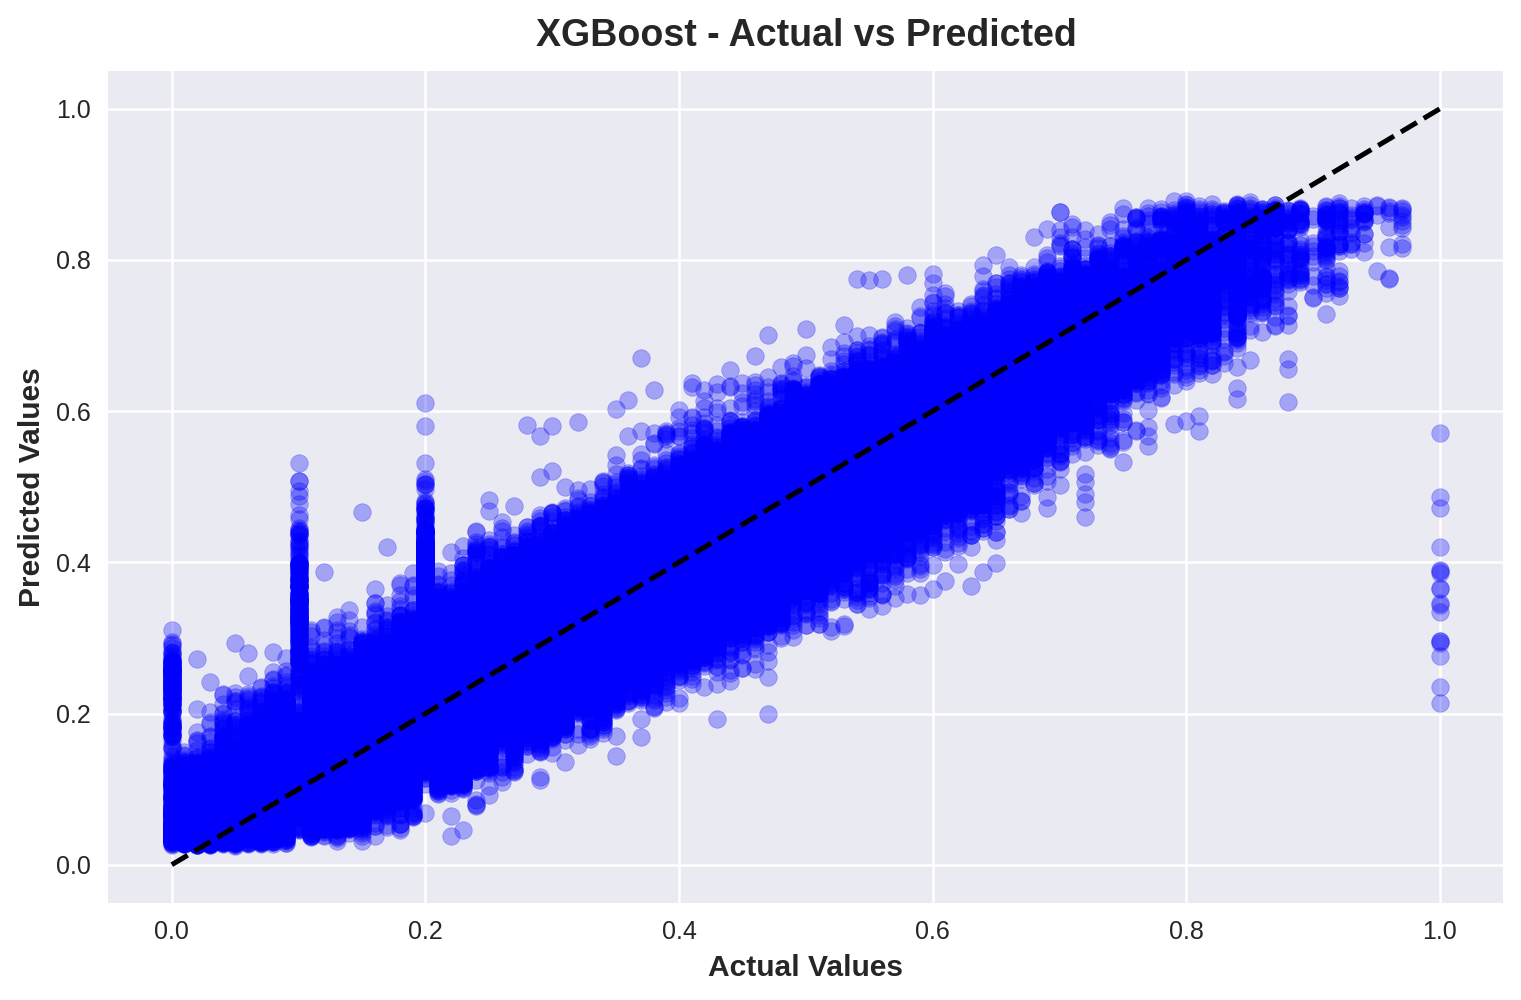

In [24]:
plt.scatter(y_valid, yhat, alpha=0.3, color='blue')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("XGBoost - Actual vs Predicted")
plt.show()

In [25]:
X_test = test.copy()
test_preds = best_model.predict(X_test)

In [26]:
sub = pd.read_csv('/kaggle/input/playground-series-s5e10/sample_submission.csv')
sub['accident_risk'] = test_preds
sub.to_csv('submission.csv', index=False)
sub.head()

,id,accident_risk
0,517754,0.295199
1,517755,0.127074
2,517756,0.180568
3,517757,0.343060
4,517758,0.379991
